# STA395 - Machine Learning 
## Data Scraping and Preprocessing

#### Import necessary libraries

In [18]:
import numpy as np
import pandas as pd
from FedTools import FederalReserveMins
import requests
import matplotlib.pyplot as plt

#### Get Federal Reserve Minutes using FedTools

In [19]:
fed_mins = FederalReserveMins(
            main_url = 'https://www.federalreserve.gov', 
            calendar_url ='https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm',
            start_year=1993,
            historical_split = 2017,
            verbose = True,
            thread_num = 1)

data = fed_mins.find_minutes()
data = data.reset_index()

Constructing links between 1993 and 2023


KeyboardInterrupt: 

#### Define function to scrape federal funds rate data

In [3]:
def scrape_federal_funds_rate(api_key, rate_start_date='1990-01-01', rate_end_date='2008-12-16', range_start_date='2008-12-17', range_end_date='2023-03-25'):
    # Fetch target federal funds rate
    url_target_rate = f"https://api.stlouisfed.org/fred/series/observations?series_id=DFEDTAR&api_key={api_key}&file_type=json&observation_start={rate_start_date}&observation_end={rate_end_date}"
    response_target_rate = requests.get(url_target_rate)

    # Fetch target range lower limit
    url_lower_limit = f"https://api.stlouisfed.org/fred/series/observations?series_id=DFEDTARL&api_key={api_key}&file_type=json&observation_start={range_start_date}&observation_end={range_end_date}"
    response_lower_limit = requests.get(url_lower_limit)

    # Fetch target range upper limit
    url_upper_limit = f"https://api.stlouisfed.org/fred/series/observations?series_id=DFEDTARU&api_key={api_key}&file_type=json&observation_start={range_start_date}&observation_end={range_end_date}"
    response_upper_limit = requests.get(url_upper_limit)

    if all(response.status_code == 200 for response in [response_target_rate, response_lower_limit, response_upper_limit]):
        target_rate_data = response_target_rate.json()['observations']
        lower_limit_data = response_lower_limit.json()['observations']
        upper_limit_data = response_upper_limit.json()['observations']

        date_rate_data = []

        for target_rate in target_rate_data:
            date = target_rate['date']
            rate = target_rate['value'] if target_rate['value'] != '.' else 'NA'
            date_rate_data.append((date, rate, 'NA', 'NA', 'NA'))

        for lower_limit, upper_limit in zip(lower_limit_data, upper_limit_data):
            date = lower_limit['date']
            lower = lower_limit['value'] if lower_limit['value'] != '.' else 'NA'
            upper = upper_limit['value'] if upper_limit['value'] != '.' else 'NA'
            avg_range = (float(lower) + float(upper)) / 2 if lower != 'NA' and upper != 'NA' else 'NA'

            date_rate_data.append((date, 'NA', lower, upper, avg_range))

        # Convert data to a pandas DataFrame
        df = pd.DataFrame(date_rate_data, columns=['Date', 'Target Rate', 'Lower Limit', 'Upper Limit', 'Average Range'])
        return df
    else:
        print(f"Error: Unable to fetch data. Status codes: {response_target_rate.status_code}, {response_lower_limit.status_code}, {response_upper_limit.status_code}")
        return None

api_key = "205481b5b63bdb476a6fd5ef5f57023c"
federal_funds_rate_data = scrape_federal_funds_rate(api_key)
federal_funds_rate_data

,Date,Target Rate,Lower Limit,Upper Limit,Average Range
0,1990-01-01,8.25,NA,NA,NA
1,1990-01-02,8.25,NA,NA,NA
2,1990-01-03,8.25,NA,NA,NA
3,1990-01-04,8.25,NA,NA,NA
4,1990-01-05,8.25,NA,NA,NA
...,...,...,...,...,...
12131,2023-03-21,NA,4.50,4.75,4.625
12132,2023-03-22,NA,4.50,4.75,4.625
12133,2023-03-23,NA,4.75,5.00,4.875
12134,2023-03-24,NA,4.75,5.00,4.875


#### Preprocess the fetched federal funds rate data

In [4]:
federal_funds_rate_data["Date"] = pd.to_datetime(federal_funds_rate_data["Date"])
cols = ["Target Rate", "Lower Limit", "Upper Limit", "Average Range"]
lead_cols = [col + '_lead' for col in cols]
federal_funds_rate_data[lead_cols] = federal_funds_rate_data[cols].apply(lambda x: x.shift(-1))

#### Merge data and drop unnecessary columns

In [5]:
data_merged = data.merge(federal_funds_rate_data, left_on = 'index', right_on= 'Date')
drops = ["Date", "Target Rate", "Lower Limit", "Upper Limit", "Average Range"]
df = data_merged.drop(drops, axis= 1)


#### Rename columns

In [6]:
new_names = {"index": "date",
             "Federal_Reserve_Mins": "minutes",
             "Target Rate_lead": "tar_rate",
             "Lower Limit_lead": "lower_limit_range",
             "Upper Limit_lead": "upper_limit_range",
             "Average Range_lead": "avg_range"}

df.rename(columns=new_names, inplace = True)

#### Define function to replace 'NA' strings with 0

In [7]:
def replace_na_with_zero(df):
    df = df.replace('NA', 0)
    return df

df = replace_na_with_zero(df)
cols = ["tar_rate", "lower_limit_range", "upper_limit_range", "avg_range"]
df[cols] = df[cols].apply(pd.to_numeric)

#### Calculate the new target rate and drop the old columns

In [8]:
df["tar_rate_new"] = df["tar_rate"] + df["upper_limit_range"]
cols_new = ["tar_rate", "lower_limit_range", "upper_limit_range", "avg_range"]
df = df.drop(cols_new, axis=1)

In [9]:
# # Check the range of the upper and lower limit
# df["diff"] = df["upper_limit_range"] -  df["lower_limit_range"]
# df["diff"].unique()
df

,date,minutes,tar_rate_new
0,1993-02-03,A meeting of the Federal Open Market Committee...,3.00
1,1993-03-23,A meeting of the Federal Open Market Committee...,3.00
2,1993-05-18,A meeting of the Federal Open Market Committee...,3.00
3,1993-07-07,A meeting of the Federal Open Market Committee...,3.00
4,1993-08-17,A meeting of the Federal Open Market Committee...,3.00
...,...,...,...
235,2022-09-21,"The Federal Reserve, the central bank of the U...",3.25
236,2022-11-02,"The Federal Reserve, the central bank of the U...",4.00
237,2022-12-14,"The Federal Reserve, the central bank of the U...",4.50
238,2023-02-01,"The Federal Reserve, the central bank of the U...",4.75


Since 0.25 is the only range. We can just take the upper range as our target rate instead of the average value. We create a new column to reflect our target rate, by combining the original target rate pre-2008 and the upper range post-2008

#### Create prediction variable (next meeting target rate)

In [10]:
df["next_tar_rate"] = df["tar_rate_new"].shift(-1)
df

,date,minutes,tar_rate_new,next_tar_rate
0,1993-02-03,A meeting of the Federal Open Market Committee...,3.00,3.00
1,1993-03-23,A meeting of the Federal Open Market Committee...,3.00,3.00
2,1993-05-18,A meeting of the Federal Open Market Committee...,3.00,3.00
3,1993-07-07,A meeting of the Federal Open Market Committee...,3.00,3.00
4,1993-08-17,A meeting of the Federal Open Market Committee...,3.00,3.00
...,...,...,...,...
235,2022-09-21,"The Federal Reserve, the central bank of the U...",3.25,4.00
236,2022-11-02,"The Federal Reserve, the central bank of the U...",4.00,4.50
237,2022-12-14,"The Federal Reserve, the central bank of the U...",4.50,4.75
238,2023-02-01,"The Federal Reserve, the central bank of the U...",4.75,5.00


In [11]:
# From this link: https://www.federalreserve.gov/newsevents/pressreleases/monetary20230503a.htm
# The feds increase rate from 5.00 to 5.25 in the next meeting
# Therfore I replace the NaN value in row 239 (March 22, 2023 meeting) with 5.25
# Only one NaN values, which is the thing i want to replace
df.isna().sum().sum()

1

In [15]:
df = df.replace(np.nan, 5.25)

In [21]:
df["change"] = df["next_tar_rate"] - df["tar_rate_new"]
df["does_change"] = df["change"].apply(lambda x: 0 if x == 0 else 1)
df

,date,minutes,tar_rate_new,next_tar_rate,change,does_change
0,1993-02-03,A meeting of the Federal Open Market Committee...,3.00,3.00,0.00,0
1,1993-03-23,A meeting of the Federal Open Market Committee...,3.00,3.00,0.00,0
2,1993-05-18,A meeting of the Federal Open Market Committee...,3.00,3.00,0.00,0
3,1993-07-07,A meeting of the Federal Open Market Committee...,3.00,3.00,0.00,0
4,1993-08-17,A meeting of the Federal Open Market Committee...,3.00,3.00,0.00,0
...,...,...,...,...,...,...
235,2022-09-21,"The Federal Reserve, the central bank of the U...",3.25,4.00,0.75,1
236,2022-11-02,"The Federal Reserve, the central bank of the U...",4.00,4.50,0.50,1
237,2022-12-14,"The Federal Reserve, the central bank of the U...",4.50,4.75,0.25,1
238,2023-02-01,"The Federal Reserve, the central bank of the U...",4.75,5.00,0.25,1


In [26]:
df["does_change"].value_counts()

0    164
1     76
Name: does_change, dtype: int64

In [39]:
# Save the DataFrame to a CSV file
df.to_csv("fomc_data_final.csv", index = False)

#### Plotting

<AxesSubplot: xlabel='date'>

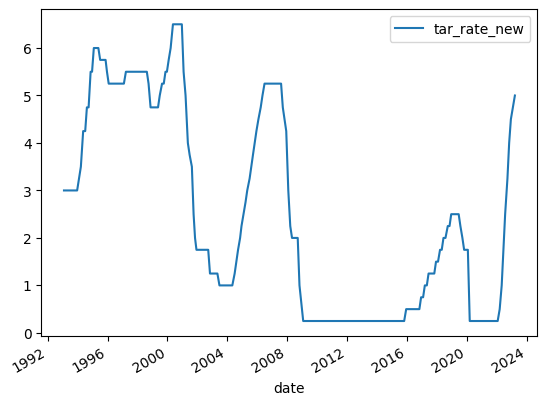

In [37]:
df.plot("date", "tar_rate_new")

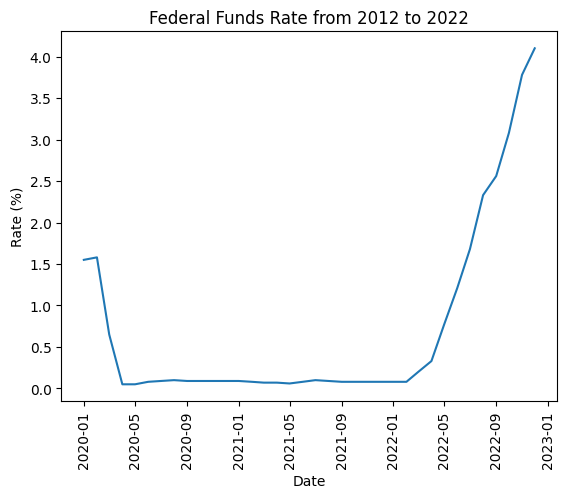

In [4]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt

start_date = '2020-01-01'
end_date = '2022-12-31'

fed_funds_rate = web.DataReader('FEDFUNDS', 'fred', start_date, end_date)

plt.plot(fed_funds_rate)
plt.title('Federal Funds Rate from 2012 to 2022')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Rate (%)')
plt.show()

In [38]:
df["change"].unique()

array([ 0.  ,  0.25,  0.75,  0.5 , -0.25, -0.5 , -1.  , -1.25, -0.75,
       -1.5 ])

In [5]:
from transformers import BertTokenizer, BertModel

# Initialize a tokenizer and a model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Let's consider the following text
text = ["this is an example", "this is another example"]

# Tokenize the text
tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

# tokens is a dictionary that contains 'input_ids' and 'attention_mask'
input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']

print('Input IDs:', input_ids)
print('Attention Mask:', attention_mask)

# Pass the tokens to the model to get the embeddings
outputs = model(input_ids, attention_mask)

# 'outputs' is a tuple, the first element of which is the embeddings tensor
embeddings = outputs[0]

print('Embeddings:', embeddings)

# Extract the [CLS] token's embedding
cls_embedding = embeddings[:, 0, :]

print('CLS Embedding:', cls_embedding)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Input IDs: tensor([[ 101, 2023, 2003, 2019, 2742,  102],
        [ 101, 2023, 2003, 2178, 2742,  102]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]])
Embeddings: tensor([[[-2.0596e-01,  9.5147e-02, -8.2840e-02,  ..., -3.6662e-01,
           4.6256e-01,  6.9678e-01],
         [-5.5570e-01, -4.1348e-01,  2.5046e-01,  ..., -6.3024e-01,
           8.2961e-01,  1.1416e-01],
         [-1.9147e-01, -6.5897e-01,  7.8237e-01,  ..., -2.2145e-01,
           6.0788e-01,  7.2486e-01],
         [-2.6714e-01, -5.1210e-01,  7.7224e-01,  ...,  1.2525e-01,
           6.3272e-01,  1.3925e+00],
         [-5.7207e-01, -1.8810e-01, -3.4591e-02,  ..., -2.4534e-01,
           5.6087e-01,  4.0126e-01],
         [ 9.3498e-01,  9.8734e-02, -2.5121e-01,  ...,  3.1891e-01,
          -7.7884e-01, -1.4572e-01]],

        [[-6.7175e-02,  7.3521e-02, -4.4378e-02,  ..., -2.5377e-01,
           5.2185e-01,  6.3348e-01],
         [-3.0976e-01, -5.4706e-01,  2.5921e-01,  ..., -4.9619e-01,
      

In [16]:
embeddings[:, 0, :].shape

torch.Size([2, 768])

In [17]:
embeddings.shape

torch.Size([2, 6, 768])